#  Main Experiment: Event Time DiD + Event Study Image Analysis


In [28]:
import pandas as pd
data=pd.read_csv("robust_df.csv")
print(data.dtypes)

Date                object
ticker              object
Close              float64
Return             float64
Treatment            int64
expected_return    float64
abnormal_return    float64
event_id            object
event_date          object
event_time         float64
CAR_pre            float64
CAR_post           float64
delta_CAR          float64
post                 int64
CAR                float64
dtype: object


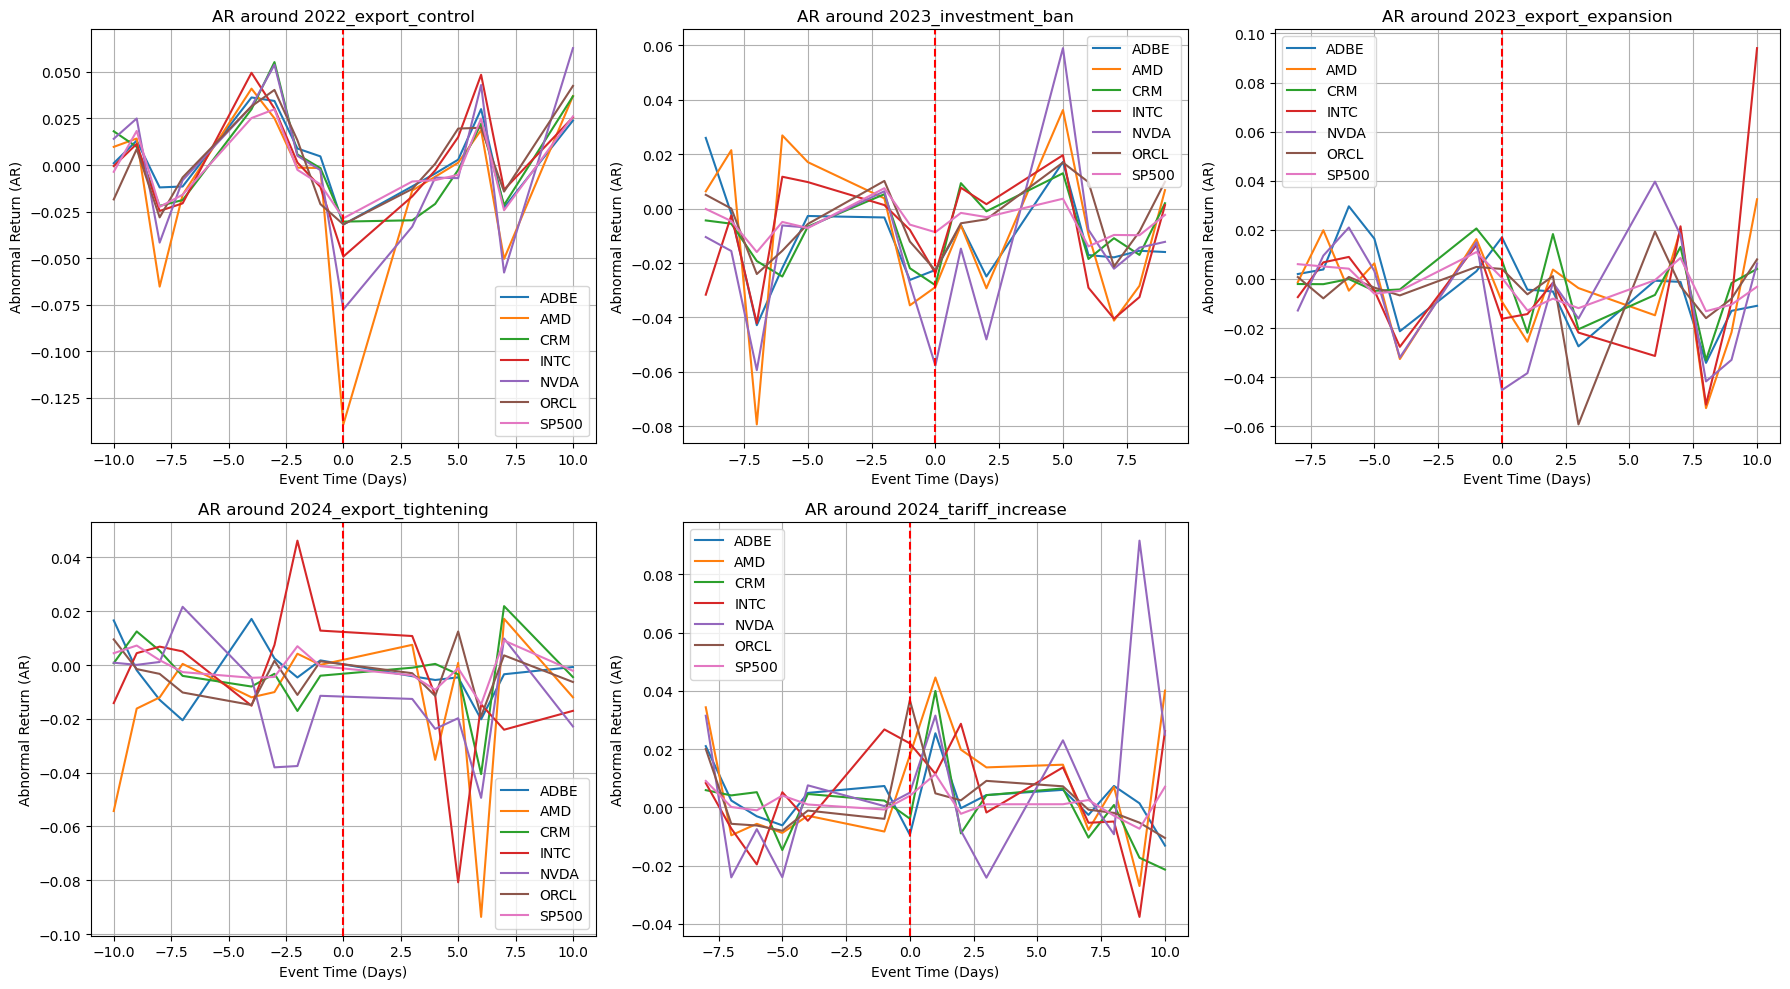

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


event_dict = {
    "2022_export_control": pd.to_datetime("2022-10-07"),
    "2023_investment_ban": pd.to_datetime("2023-08-09"),
    "2023_export_expansion": pd.to_datetime("2023-10-17"),
    "2024_export_tightening": pd.to_datetime("2024-03-29"),
    "2024_tariff_increase": pd.to_datetime("2024-05-14"),
}


all_tickers = sorted(data['ticker'].unique())


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()


for i, (event_id, event_date) in enumerate(event_dict.items()):
    ax = axes[i]
    for ticker in all_tickers:
        sub_df = data[
            (data['event_id'] == event_id) &
            (data['ticker'] == ticker) &
            (data['event_time'].between(-10, 10))
        ].sort_values('event_time')
        sns.lineplot(x='event_time', y='abnormal_return', data=sub_df, label=ticker, ax=ax)

    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(f"AR around {event_id}")
    ax.set_xlabel("Event Time (Days)")
    ax.set_ylabel("Abnormal Return (AR)")
    ax.grid(True)


handles, labels = ax.get_legend_handles_labels()
axes[-1].legend(handles, labels, loc='upper right')


if len(event_dict) < len(axes):
    for j in range(len(event_dict), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 1. Constructing Event-Time Panel Data

In [37]:
import pandas as pd
import statsmodels.formula.api as smf

# Load data
data = pd.read_csv("robust_df.csv")

# Convert 'Date' and 'event_date' to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['event_date'] = pd.to_datetime(data['event_date'])

# Filter out rows where 'event_id' is NaN
data = data.dropna(subset=["event_id"])

#Remove the day before the event (k = -1) as the base period
df_reg = data[data['event_time'] != -1]#The last time point “not affected by policy”

# Make sure 'event_time' is a categorical variable
df_reg['event_time'] = df_reg['event_time'].astype('category')

# Select the relevant columns for Event-time DiD analysis
df_reg = df_reg[['ticker', 'event_id', 'event_time', 'Treatment', 'abnormal_return', 'CAR']]



/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_92479/240683078.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['event_time'] = df_reg['event_time'].astype('category')


In [34]:
# test
print(df_reg['Treatment'].value_counts())
print(df_reg['event_time'].value_counts())

print(df_reg.isnull().sum())  # should all be 0
print(df_reg.duplicated().sum())  # should no replicate



Treatment
0    336
1    252
Name: count, dtype: int64
event_time
-7.0     42
 7.0     42
-4.0     35
-8.0     35
 6.0     35
 10.0    35
 3.0     35
 0.0     35
 8.0     28
 9.0     28
-5.0     28
-6.0     28
 1.0     28
 2.0     28
-10.0    21
-9.0     21
-2.0     21
-3.0     21
 5.0     21
 4.0     21
Name: count, dtype: int64
ticker        0
event_id      0
event_time    0
Treatment     0
Return        0
CAR           0
dtype: int64
0


## 2. Defining the Regression Model (Event-time DiD)

The Event-time DiD model is specified as follows:

$$
Y_{iet} = \sum_{k \neq -1} \beta_k \cdot D_k + \gamma_i + \delta_e + \epsilon_{iet}
$$

Where:

- **$Y_{iet}$**: The dependent variable, such as abnormal return or cumulative abnormal return (CAR).
- **$D_k$**: The dummy variable for each relative time point $k$ (for example, $k = -5, -4, \dots, +10$).
- **$k = -1$** is used as the baseline, allowing us to estimate the treatment effect $\beta_k$ for each time point.
- **$\gamma_i$**: Firm fixed effects, controlling for firm-specific characteristics.
- **$\delta_e$**: Event fixed effects, controlling for differences in the intensity of different events.
- **$\epsilon_{iet}$**: Error term.



### The variables of interest are: Interaction term C(event_time)[T.k]:Treatment


In [38]:

model = smf.ols(
    formula="abnormal_return ~ C(event_time) * Treatment + C(ticker) + C(event_id)",
    data=df_reg
).fit(cov_type='HC1')  

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     3.716
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           3.10e-14
Time:                        16:31:42   Log-Likelihood:                 1455.8
No. Observations:                 588   AIC:                            -2812.
Df Residuals:                     538   BIC:                            -2593.
Df Model:                          49                                         
Covariance Type:                  HC1                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 50, but rank is 49
  warnings.warn('covariance of constraints does not have full '


## 3. Event-Time Coefficient Plot

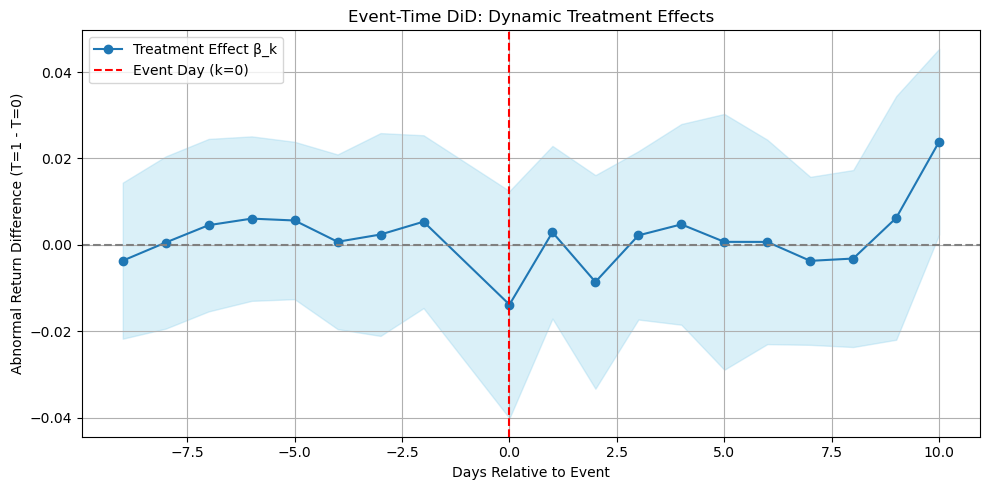

In [40]:
import matplotlib.pyplot as plt

# Extract treatment interaction coefficients and confidence intervals
coef_series = model.params.filter(like='C(event_time)[T.')
conf_int = model.conf_int().loc[coef_series.index]
treat_interact = coef_series[coef_series.index.str.contains(':Treatment')]
conf_int_treat = conf_int.loc[treat_interact.index]

# Clean up event_time keys and convert to float
event_days = [float(i.split('[')[1].split(']')[0].split(':')[0].replace('T.', '')) for i in treat_interact.index]
betas = treat_interact.values
lower = conf_int_treat[0].values
upper = conf_int_treat[1].values

# Sort by event_days
sorted_idx = sorted(range(len(event_days)), key=lambda i: event_days[i])
event_days = [event_days[i] for i in sorted_idx]
betas = [betas[i] for i in sorted_idx]
lower = [lower[i] for i in sorted_idx]
upper = [upper[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(event_days, betas, marker='o', label='Treatment Effect β_k')
plt.fill_between(event_days, lower, upper, alpha=0.3, color='skyblue')
plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='red', label='Event Day (k=0)')
plt.xlabel("Days Relative to Event")
plt.ylabel("Abnormal Return Difference (T=1 - T=0)")
plt.title("Event-Time DiD: Dynamic Treatment Effects")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This figure plots the estimated treatment effects of hardware dependency on abnormal stock returns over the event time window. Each dot represents the estimated difference in abnormal returns between hardware-dependent and non-hardware-dependent AI firms, at a given day relative to policy announcement. The shaded area indicates the 95% confidence interval.



## 5. Explana & Conclusion 


#### 1. Pre-trends (Days < 0)
- **Observation**:  
  Treatment and control groups show no significant difference before the event.  
- **Implication**:  
  Supports the **parallel trends assumption**, a key requirement for causal identification in DiD.

#### 2. Event Day (k=0)
- **Observation**:  
  A negative dip occurs, but it's **not statistically significant** (confidence interval overlaps 0).  
- **Implication**:  
  No immediate market crash, but suggests initial shock absorption may begin.

#### 3. Post-event Dynamics (Days > 0)
- **Key Findings**:  
  - From **k=8 to k=10**, treatment firms exhibit **positive abnormal returns** relative to control firms.  
  - The effect at **k=10** is **statistically significant** (p < 0.05).  
- **Interpretation**:  
  Delayed market reaction, possibly due to:  
  - Investor re-evaluation of treatment firms.  
  - Gradual recovery after initial uncertainty.  


/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_92479/2463965664.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  SP500_event_df = sp500_df.groupby('event_time').agg(


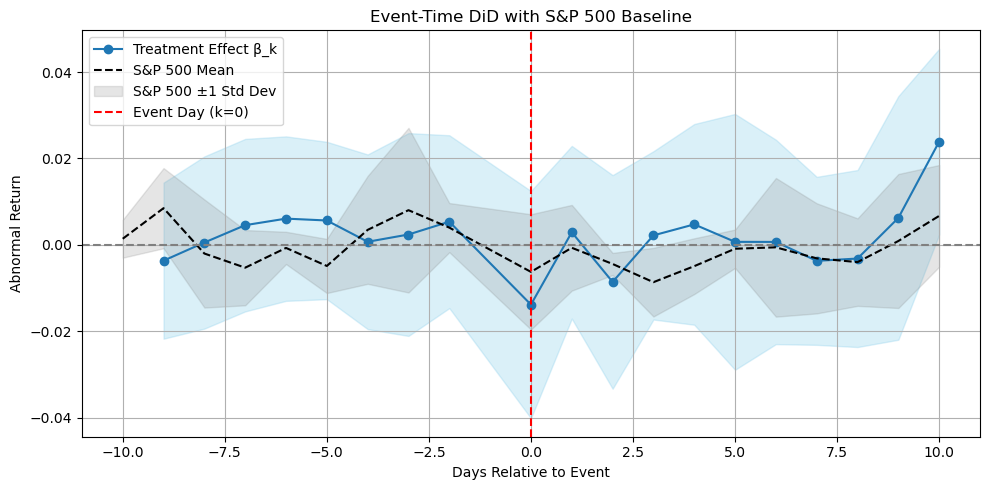

In [ ]:

# 1. S&P 500 baseline dataframe
sp500_df = df_reg[df_reg['ticker'] == 'SP500']

SP500_event_df = sp500_df.groupby('event_time').agg(
    AR_mean_SP500=('abnormal_return', 'mean'),
    AR_std_SP500=('abnormal_return', 'std')
).reset_index()

# 2.  Treatment × Event_Time coeff
coef_series = model.params.filter(like='C(event_time)[T.')
conf_int = model.conf_int().loc[coef_series.index]
treat_interact = coef_series[coef_series.index.str.contains(':Treatment')]
conf_int_treat = conf_int.loc[treat_interact.index]

event_days = [float(i.split('[')[1].split(']')[0].split(':')[0].replace('T.', '')) for i in treat_interact.index]
betas = treat_interact.values
lower = conf_int_treat[0].values
upper = conf_int_treat[1].values

sorted_idx = sorted(range(len(event_days)), key=lambda i: event_days[i])
event_days = [event_days[i] for i in sorted_idx]
betas = [betas[i] for i in sorted_idx]
lower = [lower[i] for i in sorted_idx]
upper = [upper[i] for i in sorted_idx]

plt.figure(figsize=(10, 5))

# Treatment Effect β_k
plt.plot(event_days, betas, marker='o', label='Treatment Effect β_k')
plt.fill_between(event_days, lower, upper, alpha=0.3, color='skyblue')

# S&P 500 baseline
plt.plot(SP500_event_df['event_time'], SP500_event_df['AR_mean_SP500'],
         linestyle='--', color='black', label='S&P 500 Mean')
plt.fill_between(SP500_event_df['event_time'],
                 SP500_event_df['AR_mean_SP500'] - SP500_event_df['AR_std_SP500'],
                 SP500_event_df['AR_mean_SP500'] + SP500_event_df['AR_std_SP500'],
                 color='gray', alpha=0.2, label='S&P 500 ±1 Std Dev')

plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='red', label='Event Day (k=0)')

plt.xlabel("Days Relative to Event")
plt.ylabel("Abnormal Return")
plt.title("Event-Time DiD with S&P 500 Baseline")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Dynamic Treatment Effects with S&P 500 Baseline

The plot below visualizes the estimated dynamic treatment effects of hardware dependency on AI firms' abnormal returns around trade war-related policy announcements, using an event-time Difference-in-Differences (DiD) framework. 

The solid blue line represents the estimated differences in abnormal returns between hardware-dependent (treatment) and non-hardware-dependent (control) firms at each day relative to the event date (k=0). Shaded areas indicate 95% confidence intervals for these estimates.

To benchmark these effects against broader market dynamics, we also plot the S&P 500’s average abnormal return over the same event window (dashed black line), with its ±1 standard deviation shown as a gray shaded region.

**Key Observations:**
- **Pre-trend check (k < 0):** No significant deviation between treatment and control groups, supporting the parallel trends assumption.
- **Immediate reaction (k = 0):** A dip is observed, but remains statistically insignificant.
- **Delayed divergence (k = 10):** The treatment effect significantly exceeds both the control group and the S&P 500 range, suggesting that hardware-dependent firms may exhibit delayed positive adjustments post-policy shock.

This analysis highlights that structural exposure to hardware may not lead to immediate market penalties, but can result in notable divergences several days after trade-related announcements.


### Regression Interpretation: Event-Time DiD with Firm and Event Fixed Effects

We estimate an event-time Difference-in-Differences (DiD) model to examine how hardware-dependent AI firms respond to trade war-related policy shocks in terms of abnormal returns. The model includes firm fixed effects (to account for unobserved firm-level heterogeneity) and event fixed effects (to absorb shock-level intensity differences). 

The regression uses `abnormal_return` as the outcome variable and estimates interaction terms for each `event_time` (days relative to the policy event) and the `Treatment` dummy (hardware-dependent firms). The omitted baseline is `event_time = -1`.

---

### Key Findings from Regression Output

#### Pre-Trends (event_time < 0):
- The interaction terms from `k = -10` to `k = -2` (e.g., `C(event_time)[T.-7.0]:Treatment`, `T.-4.0`, etc.) are **statistically insignificant**.
- → This supports the **parallel trends assumption**, validating causal interpretation of post-event estimates.

#### Event Day (k = 0):
- Coefficient: `-0.0138` | p = 0.302
- → Suggests a slight negative dip in abnormal returns for hardware-dependent firms on the day of policy announcements, but **not statistically significant**.

#### Delayed Treatment Effect (Post-event):
- At `k = 10`, the interaction term `C(event_time)[T.10.0]:Treatment` is **positive and statistically significant**:  
  - **β = 0.0239**, **p = 0.029**, 95% CI = [0.002, 0.045]
- → Indicates that **hardware-dependent firms experience a delayed positive abnormal return**, not seen in control firms or the S&P 500 baseline.

---

### Visual Confirmation

The dynamic treatment effect plot further illustrates:
- A flat pre-trend
- A mild, insignificant dip at `k = 0`
- A sharp, statistically significant upward deviation from both the control group and the S&P 500 range at `k = 10`

This pattern reinforces the interpretation that the **positive market reaction is unique to hardware-dependent firms**, and not simply a general market phenomenon.

---

### Summary and Interpretation

> These results show that hardware-dependent AI firms do not experience a statistically significant crash in abnormal returns on the policy event day, but do exhibit a **delayed and statistically significant gain in returns** approximately 10 days later. This delayed reaction may reflect investor re-evaluation, market correction, or strategic reassessment of firm value under new policy constraints.

The findings provide **causal evidence** that a firm’s structural exposure to hardware influences how it responds to external shocks like trade war policy announcements — supporting the central research hypothesis.
